In [2]:
## extracts features from audio files and converts into numpy
import librosa
import numpy as np
import os, re, csv, sys
from datetime import datetime

global hop_length

# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
hop_length = 128


In [30]:
## return a (flatten) one-D array of mfcc of an audio file
def getMFCC(audio_file):

    y = -1
    sr = -1
    try:
        y, sr = librosa.load(audio_file)
    except FileNotFoundError:
        print('No such file or directory')

    # Compute MFCC features from the raw signal
    return librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13).flatten()

## return a (flatten) one-D array of chromagram of an audio file
def getChroma(audio_file):

    y, sr = librosa.load(audio_file)
    # Separate harmonics and percussives into two waveforms
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    # Compute chroma features from the harmonic signal
    return librosa.feature.chroma_cqt(y=y_harmonic,
                                            sr=sr).flatten()


## return a list of 1-d array of MFCC padded with 0's of ALL audio files
def getPaddedMFCC(audio_files):
    
    result = [getMFCC(f) for f in audio_files]

    ##pad arrays with 0's. Get arrays of size Max
    max_len = max([len(x) for x in result])
    padded = [np.pad(x, (0, max_len - len(x)), mode = 'constant') for x in result]

    ##sanity check
    is_shorter = sum([len(x) - max_len for x in padded])
    if is_shorter < 0:
        print('not padded well')
        return -1
    else:
        return padded

## return a list of 1-d array of chromagram padded with 0's of ALL audio files
def getPaddedChroma(audio_files):
    result = [getChroma(f) for f in audio_files]

    ##pad arrays with 0's. Get arrays of size Max
    max_len = max([len(x) for x in result])
    padded = [np.pad(x, (0, max_len - len(x)), mode = 'constant') for x in result]

    ##sanity check
    is_shorter = sum([len(x) - max_len for x in padded])
    if is_shorter < 0:
        print('not padded well')
        return -1
    else:
        return padded

In [25]:

audio_dir = '/Users/panchanok/Desktop/PyHack2019/PyHack2019/sound_samples/uservoice/'
#print(type(os.listdir(audio_file)), audio_file, audio_file[0])
audio_file = os.listdir(audio_dir)
x = audio_dir + audio_file[0]
print(x)
y, sr = librosa.load(x)

/Users/panchanok/Desktop/PyHack2019/PyHack2019/sound_samples/uservoice/sound_record.mp3


In [28]:
##will stay at the same directoty
def process_audio(audio_dir, train = True):
    
    ##save the current directory
    cwd = os.getcwd()
    
    ##change to sound file directory !!hard-coded
    #audio_dir = '/Users/panchanok/Desktop/PyHack2019/PyHack2019/sound_samples/validate/'
    os.chdir(audio_dir)
    ##list files in the directory
    audio_files = os.listdir(audio_dir)
    
    if train:
    
        print('Processing ', len(audio_files), ' files')

        print('getting mfcc')
        mfcc = getPaddedMFCC(audio_files)
        print('getting chromagram')
        chrom = getPaddedChroma(audio_files)

        ### user cannot fix this
        assert (mfcc != -1 and chrom != -1), "Audio process does not produce uniform format."

        ## concatenate mfcc and chrom features
        attr_input = [np.hstack([m, c]) for m, c in zip(mfcc, chrom)]

        ## checking the final length
        #print(len(mfcc[5]), len(chrom[5]), len(x[5]))


        ##detect targets from sound names
        p = re.compile('^[aeou]|[bcdfghjklmnpqrstwxyz]+(?=[aeiou])')
        target_input = [p.match(f).group() for f in audio_files]

        ## change back to the original path
        os.chdir(cwd)


        this_time = datetime.now().strftime('%H_%M_%S')
        attr_export_name = 'attr_in_' + this_time + '.csv'
        target_export_name = 'target_in_' + this_time + '.csv'

        with open(attr_export_name,"w+") as processed:
            csvWriter = csv.writer(processed,delimiter=',')
            csvWriter.writerows(attr_input)

        with open(target_export_name,"w+") as processed:
            csvWriter = csv.writer(processed,delimiter=',')
            csvWriter.writerows(target_input)

        ## check final lengths
        #print(len(att_input[3]), len(labeled_input[3]), labeled_input)
        print('Attribute data saved as ', attr_export_name)
        print('Target data saved as ', target_export_name)
    
    else:
        print('Process user voice')
    
        print('Processing ', audio_files, '.')
        
        print('getting mfcc')
        mfcc = getPaddedMFCC(audio_files)
        print('getting chromagram')
        chrom = getPaddedChroma(audio_files)
            
        ### user cannot fix this
        assert (mfcc != -1 and chrom != -1), "Audio process does not produce uniform format."

        ## concatenate mfcc and chrom features
        attr_input = [np.hstack([m, c]) for m, c in zip(mfcc, chrom)]
        
        os.chdir(cwd)

        user_export_name = 'user_input.csv'

        with open(user_export_name,"w+") as processed:
            csvWriter = csv.writer(processed,delimiter=',')
            csvWriter.writerows(attr_input)
            
        print('User input data saved as ', user_export_name)
            
    

If there is error from the above chunk, make sure only mp3 is included in aggr/. Check even invisible .dstore

In [3]:
validate_path = '/Users/panchanok/Desktop/PyHack2019/PyHack2019/sound_samples/validate/'
#process_audio(validate_path, train = True)

Attribute data saved as  attr_in_20_33_40.csv
Target data saved as  target_in_20_33_40.csv


In [29]:
test_path = '/Users/panchanok/Desktop/PyHack2019/PyHack2019/sound_samples/uservoice/'
process_audio(test_path, train = False)

Process user voice
Processing  ['sound_record.mp3'] .
getting mfcc
==== sound_record.mp3
[ 8.1621962e-05 -1.5067030e-04 -2.1861922e-03 ... -2.7681727e-02
 -2.7229100e-02 -3.6050588e-02]
getting chromagram
User input data saved as  user_input.csv


Try displaying audio

In [4]:
# Displays are built with matplotlib 
import matplotlib.pyplot as plt
import librosa

# Let's make plots pretty
import matplotlib.style as ms
ms.use('seaborn-muted')

# Render figures interactively in the notebook
%matplotlib nbagg

# IPython gives us an audio widget for playback
from IPython.display import Audio

<IPython.core.display.Javascript object>


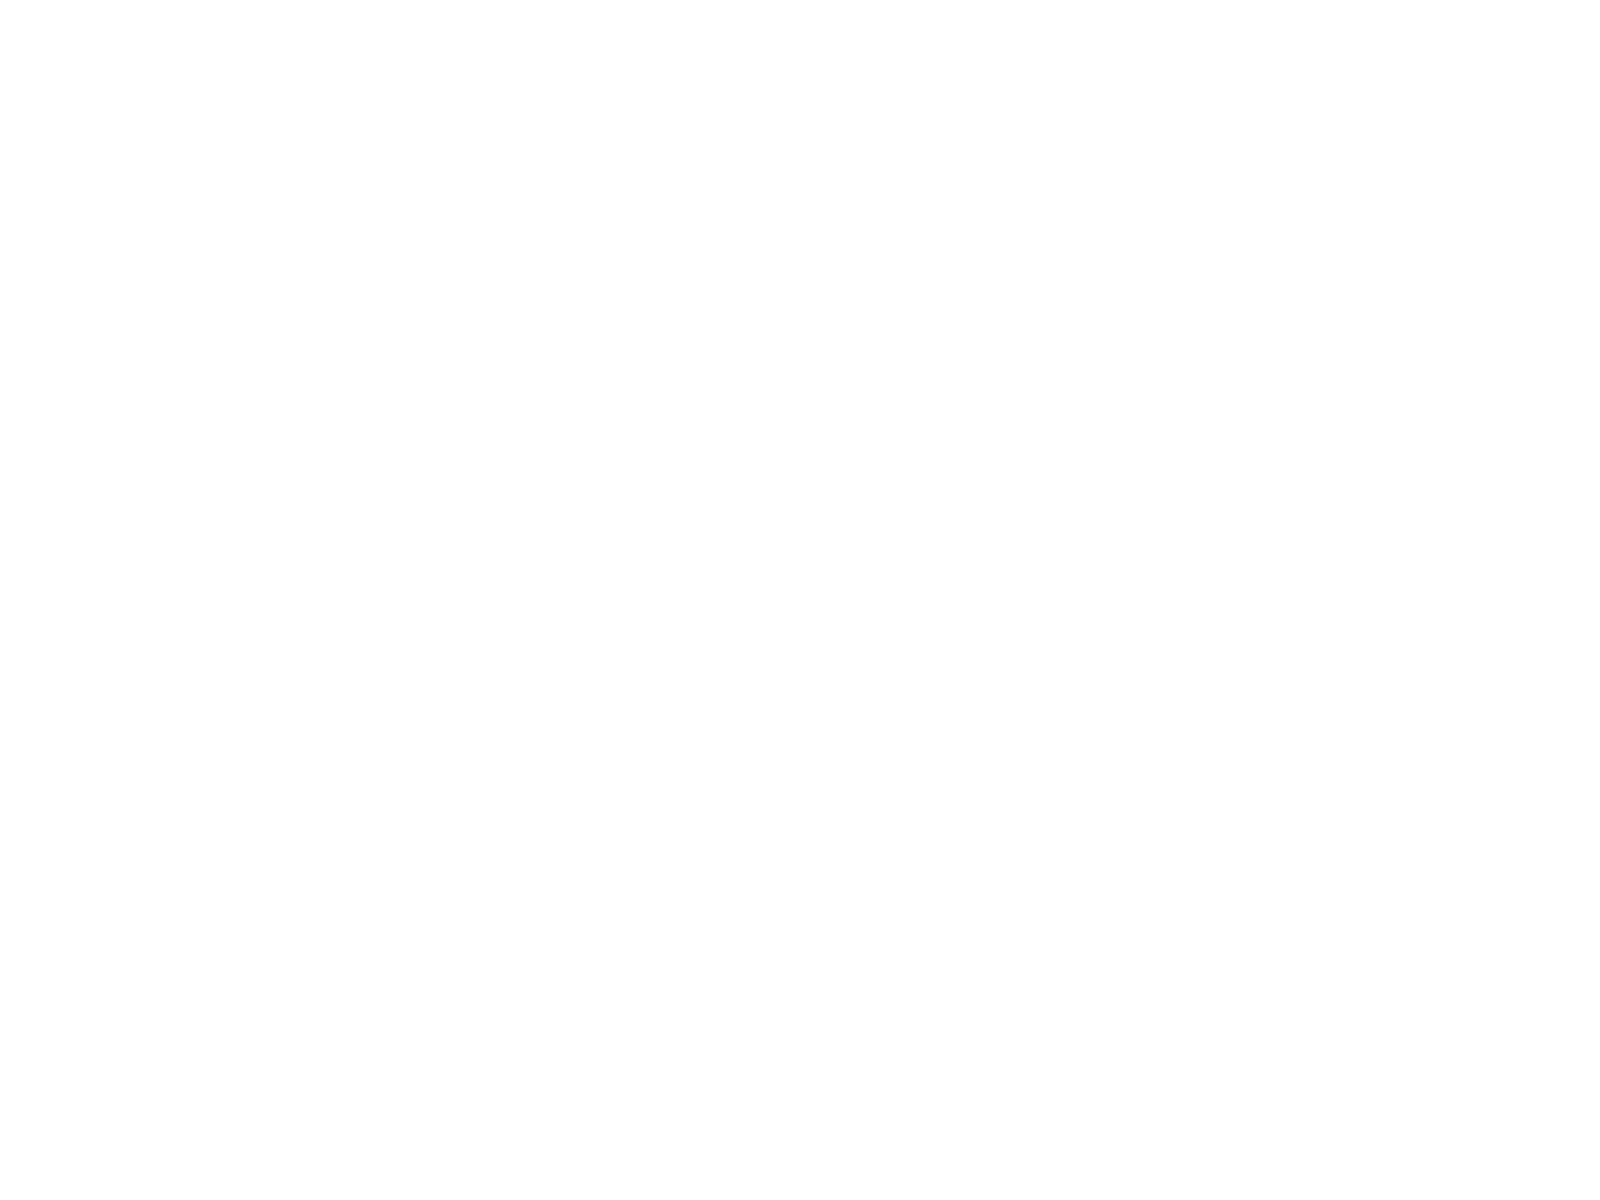

AttributeError: module 'librosa' has no attribute 'display'

In [5]:

plt.figure()
librosa.display.waveplot(y=y, sr=sr)
plt.figure()
librosa.display.specshow(melspec, y_axis='mel', x_axis='time')
plt.colorbar()